### League of Legends: Exploratory Analysis

Standard Methodology:

1. **Exploratory plots to get a sense of data (e.g. relationships, distribution etc.)**
2. Perform transformations (standardization, log-transform, PCA etc.)
3. Experiment with algorithms that make sense, feature selection and compare cross-validated performance.Algos to thinks about: Tree-Based, Basis Expansion, Logistic Regression, Discriminant  Analysis, Boosting, Neural Nets...

4. Run on test set

In [180]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve

In [181]:
def read_pickle(path):
    
    input_file = open(path,'rb')
    variable = pickle.load(input_file)
    input_file.close()
    return(variable)

In [182]:
x_train = '../data/x_train.pickle'
x_test = '../data/x_test.pickle'
y_train = '../data/y_train.pickle'
y_test = '../data/y_test.pickle'

x_train = read_pickle(x_train) 
x_test = read_pickle(x_test) 
y_train = read_pickle(y_train) 
y_test = read_pickle(y_test) 

In [183]:
#Our features have a pretty wide range. Lets start by standardizing
x = x_train.set_index('gameid').values #returns a numpy array
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
x_train = pd.DataFrame(x_scaled, columns = x_train.set_index('gameid').columns)

In [201]:
print('Total games: ', len(y_train))
print('Blue wins:', len(y_train[y_train == 1]))
print('Blue losses:', len(y_train[y_train == 0]))


Total games:  1020
Blue wins: 562
Blue losses: 458


### 1. Basic Exploratory Analysis

1. Distributions of features
2. Boxplots
3. Feature vs Feature plots

In [184]:
feature_columns = x_train.columns
feature_columns

Index(['delta_assists', 'delta_damagetochampions', 'delta_deaths',
       'delta_kills', 'delta_monsterkills', 'delta_total_cs',
       'delta_totalgold', 'delta_wardskilled', 'delta_wardsplaced',
       'delta_armor', 'delta_armorperlevel', 'delta_attackdamage',
       'delta_attackdamageperlevel', 'delta_attackrange', 'delta_attackspeed',
       'delta_attackspeedperlevel', 'delta_crit', 'delta_critperlevel',
       'delta_gap_closer_value', 'delta_hard_cc_value', 'delta_hp',
       'delta_hpperlevel', 'delta_hpregen', 'delta_hpregenperlevel',
       'delta_movespeed', 'delta_mp', 'delta_mpperlevel', 'delta_mpregen',
       'delta_mpregenperlevel', 'delta_protection_value',
       'delta_soft_cc_value', 'delta_spellblock', 'delta_spellblockperlevel',
       'delta_spells_average_range_value', 'delta_Assassin', 'delta_Fighter',
       'delta_Mage', 'delta_Marksman', 'delta_Support', 'delta_Tank',
       'gamelength'],
      dtype='object')

In [185]:
len(feature_columns)

41

In [7]:
def plot_four_hist(df, columns_list, figsize):
    
    rows = math.ceil(len(columns_list)/4)
    fig, axs = plt.subplots(nrows = rows, ncols=4, figsize = figsize)
    plt.subplots_adjust(hspace = 0.2)

    col_counter = 0
    row_counter = 0
    
    for i in columns_list:
        
        column = math.floor(col_counter/4)
        
        try:
            sns.distplot(x_train[i], ax=axs[column][row_counter], kde=False) 
        except:
            print(column + 'failed')
            continue
            #Don't plot
        
        col_counter = col_counter + 1
        row_counter = row_counter + 1
        
        if row_counter == 4:
            row_counter = 0

//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


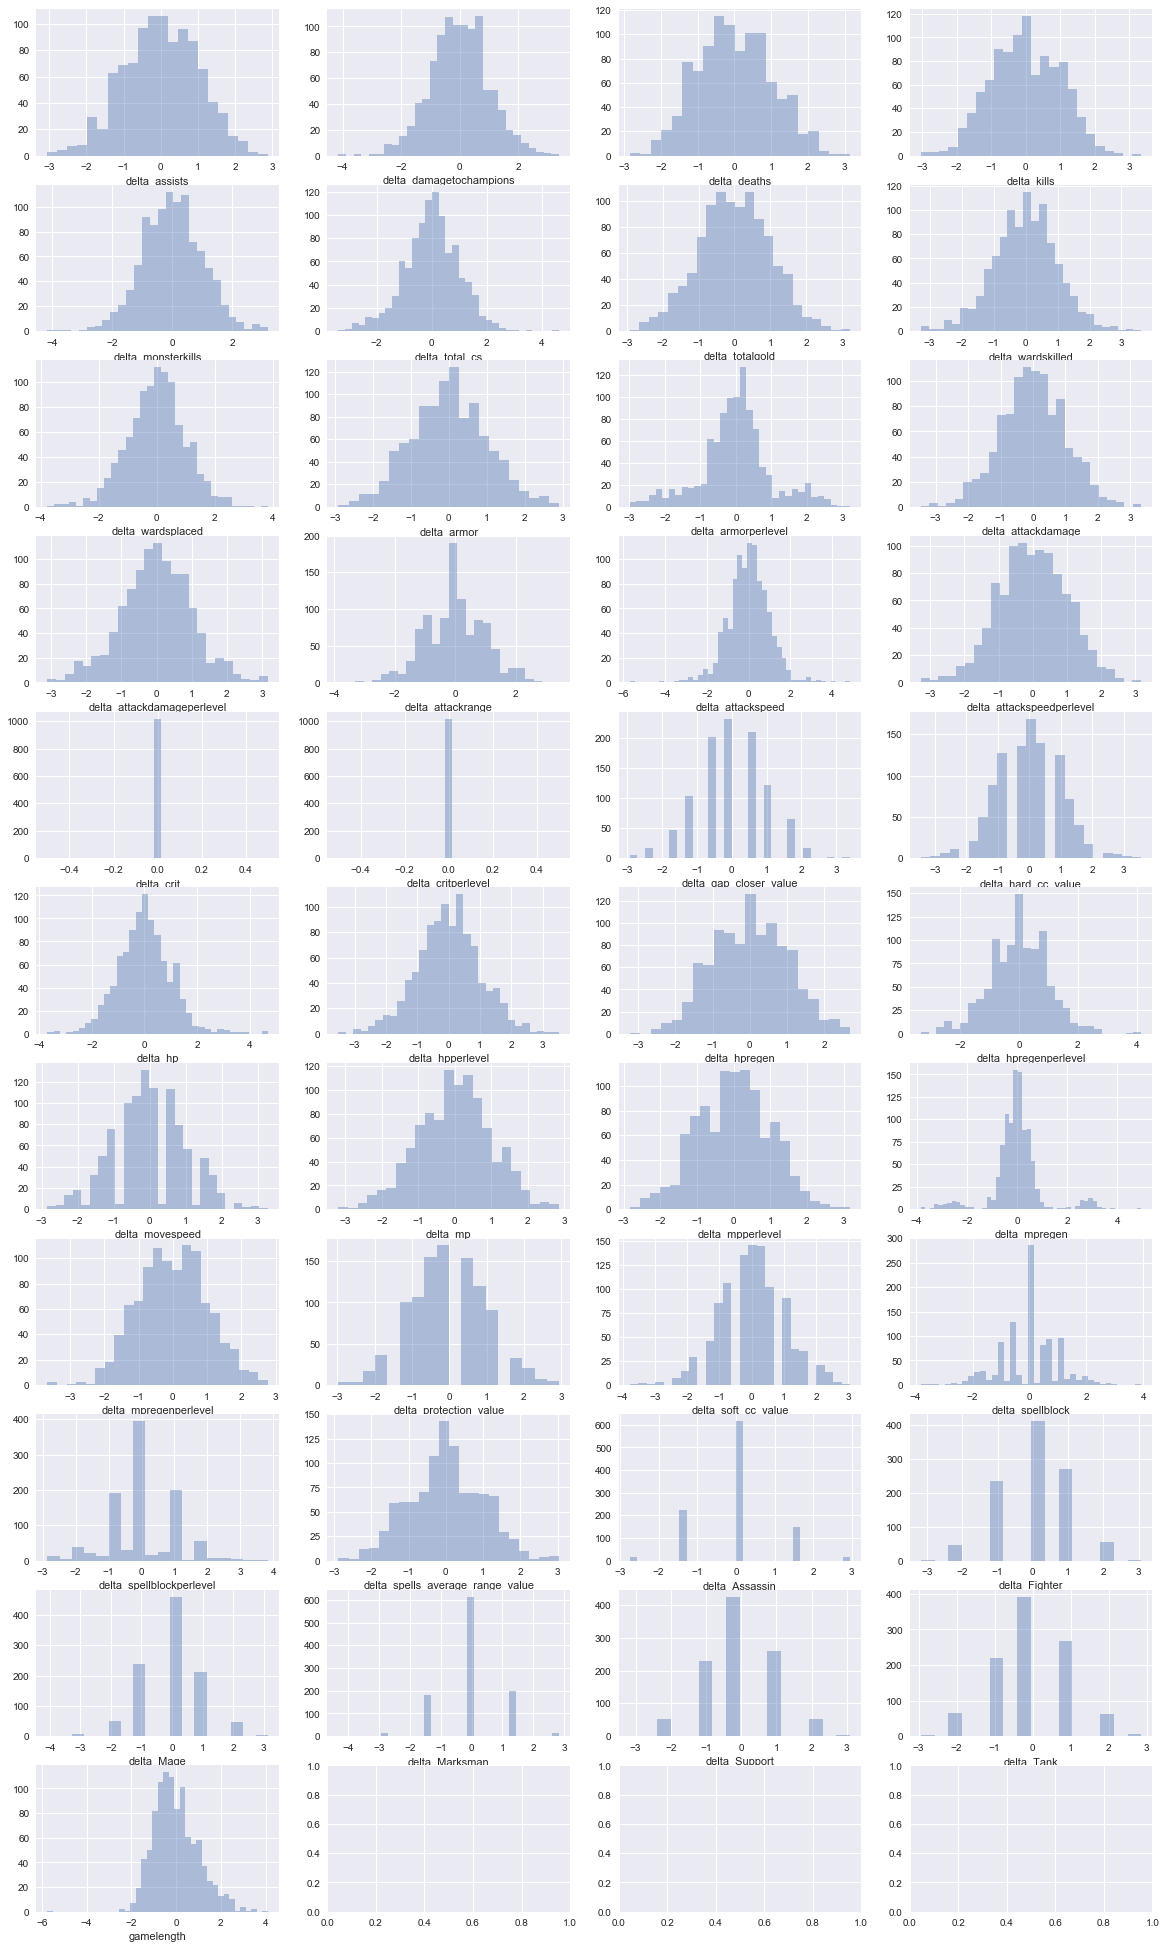

In [12]:
plot_four_hist(x_train, feature_columns, figsize = (20, 35))

Most of distributions are fairly normal looking, nothing seems to require transformations. One call out is total cs gap, that appears to be skewed left and may benefit from a log-transform. Some features may not be useful, e.g. crit is so ubiquitous to team comps that there is rarely a delta between two teams for crit. The integer features like Classes look a bit odd when visualized this way, if we adjust the bins they look relatively normal except for Marksman & Mage which are skewed right. That intuitively makes sense since those two roles are extremely prevelant in competitive play as the main carries.

In [22]:
def plot_four_boxplots(df, df_y, columns_list, figsize):
    
    rows = math.ceil(len(columns_list)/4)
    fig, axs = plt.subplots(nrows = rows, ncols=4, figsize = figsize)
    plt.subplots_adjust(hspace = 0.2)

    col_counter = 0
    row_counter = 0
    
    for i in columns_list:
        
        column = math.floor(col_counter/4)
        
        try:
            sns.boxplot(x = df_y, y = x_train[i], ax=axs[column][row_counter]) 
        except:
            print('Test bug')
            continue
            #Don't plot
        
        col_counter = col_counter + 1
        row_counter = row_counter + 1
        
        if row_counter == 4:
            row_counter = 0

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


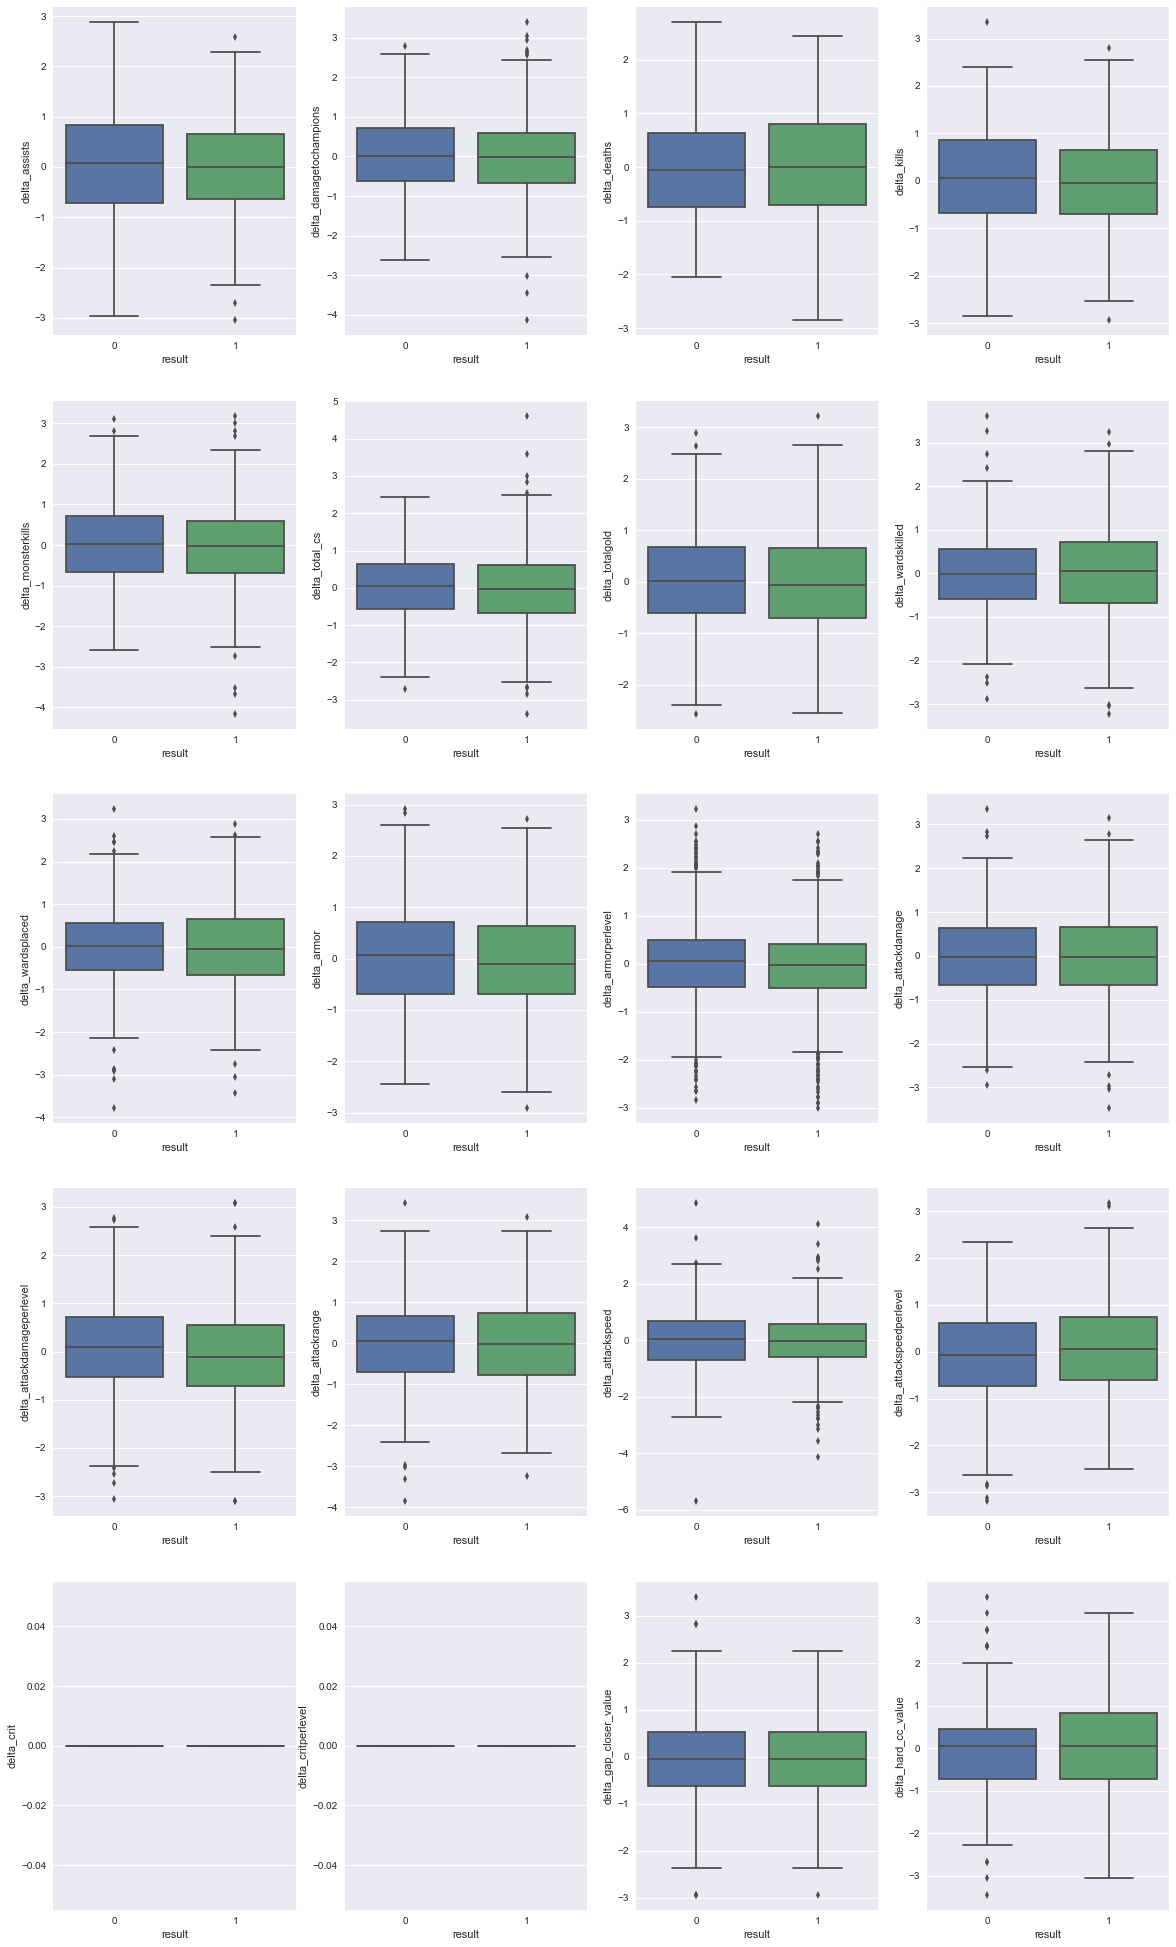

In [25]:
plot_four_boxplots(x_train, y_train, feature_columns[:20], figsize = (20, 35))

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


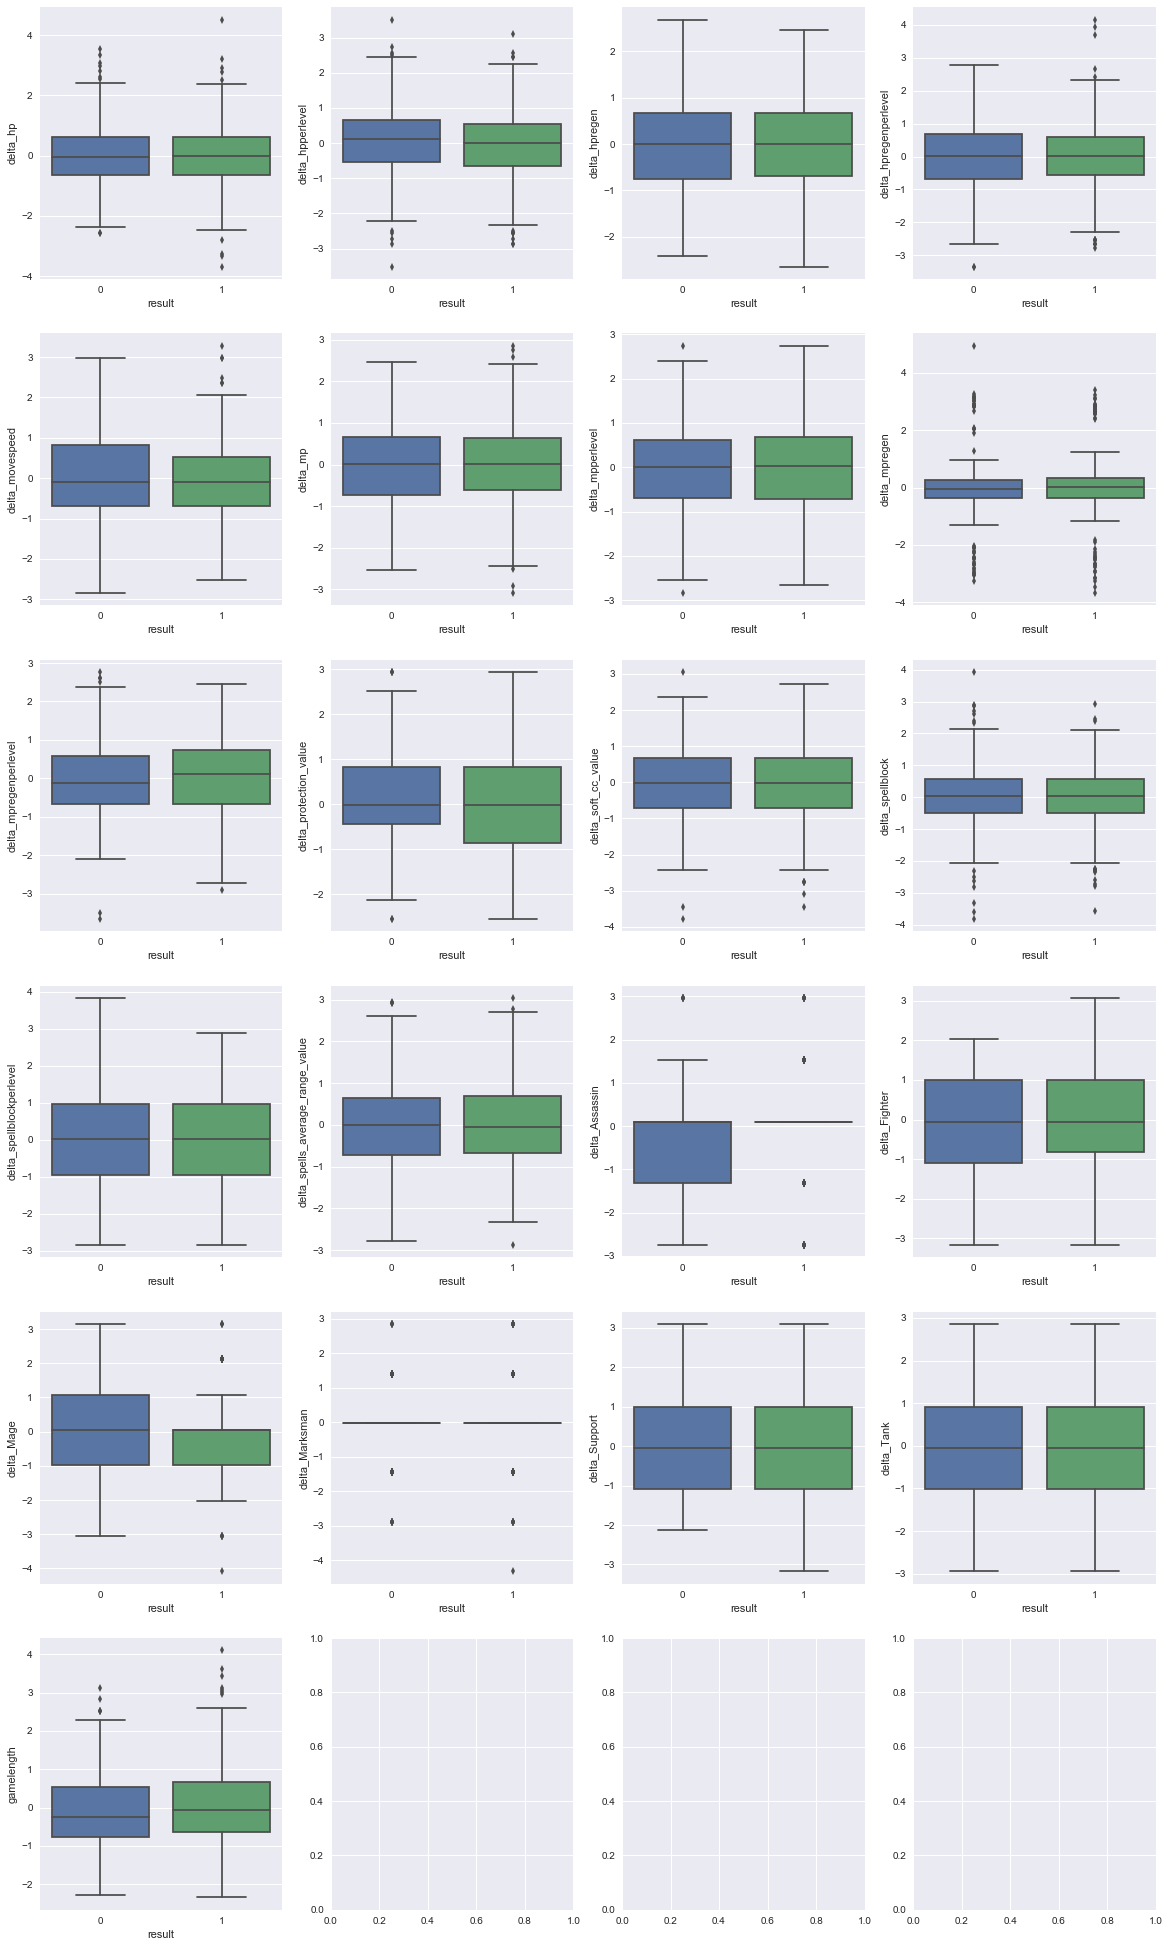

In [26]:
plot_four_boxplots(x_train, y_train, feature_columns[20:], figsize = (20, 35))

In [186]:
x_train = x_train.drop(['delta_crit', 'delta_critperlevel'], axis = 1)
feature_columns = x_train.columns

We're seeing some outliers that we might need to remove later on. In bivariate models, it seems our features are not that predictive right now. There are no clear class separation between win-loss based on the boxplots.

### Another component we want to explore is interactions.

A clear candiate is per level stats and moving average game time. In theory, teams that tend to play slower pace will see more value in per level stats since their champions will tend to be higher level. However, I think it is easier to start identifying these possible interactions by fitting basic models first.

In [187]:
per_level = [feature for feature in feature_columns if "perlevel" in feature]
interact_fields = []

for i in per_level:
    field_name = i + str('_gamelength')
    x_train[field_name] = x_train[i] * x_train['gamelength']
    interact_fields = interact_fields + [field_name]

//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


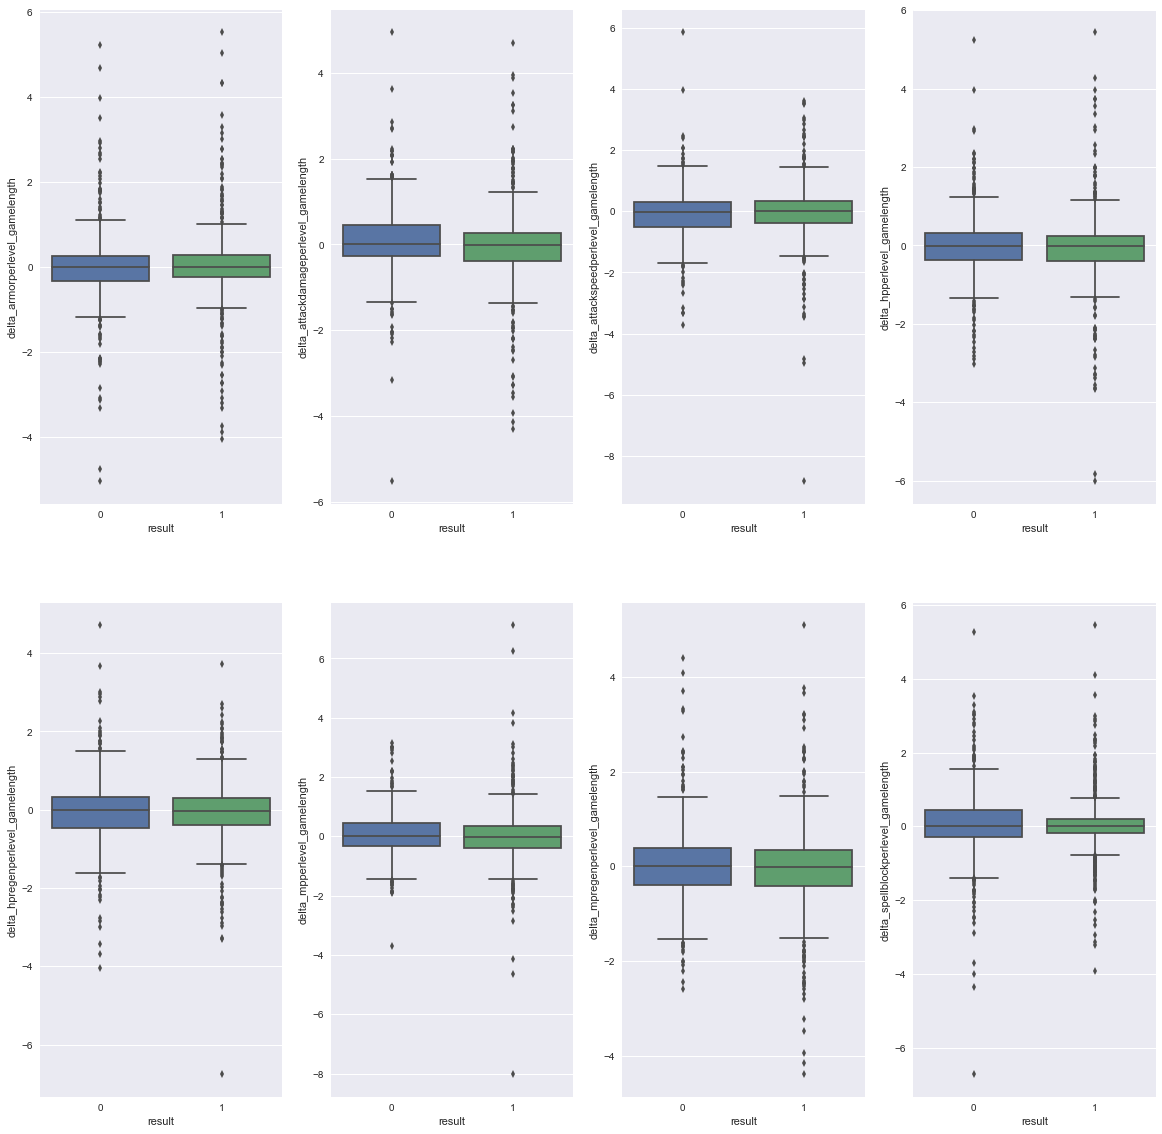

In [188]:
plot_four_boxplots(x_train, y_train, interact_fields, figsize = (20, 20))

The spread is very wide, and we don't have a good reason to blindly remove these high deviation observations as leverage points. We can still observe some differences, such as attack damage per level * game length.


### Dimensionality Reduction

Our dimensions are quite high and a lot of these features most likely tell the same story or has no correlation to our target variable at all. The two main approaches are `projection` and `manifold learning`. They are implemented through the 3 popular algorithms of i) principal component analysis (PCA) ii) kernel principal component analysis (Kernal PCA) and iii) local linear embeddings (LLE).


**PCA**: The goal of PCA is to project onto the best hyperplane by identifying components that preserve the most information. This means the goal is to maximize variance (high variance implies difference in the data, and thats information).

In [189]:
pca = PCA() #use all components for now
x_pca = pca.fit_transform(x_train.values)

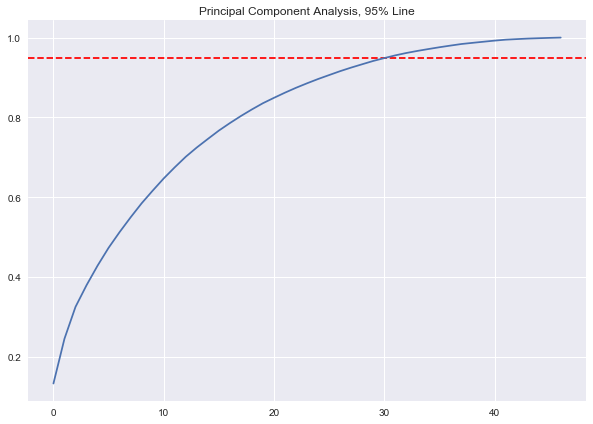

In [190]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Principal Component Analysis, 95% Line')
ax.axhline(0.95, ls='--', color = 'red')
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Based on PCA, it actually seems like the variables are quite distinct and each component is only explaining a small portion of the variance. The curve starts to flatten around 35 and exceeds 95% explained variance ratio at about 30 components. We can consider limiting to 30 components.

In [191]:
pca = PCA(n_components = 30) #subtracting out crit columns
x_pca = pca.fit_transform(x_train.values)

log_reg_model = LogisticRegression()
#log_reg_model.fit(x_pca, y_train)

scores = cross_val_score(log_reg_model, x_pca, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
rmse_scores

array([0.36867646, 0.35526552, 0.44280744, 0.40824829, 0.49507377,
       0.46442036, 0.47485808, 0.40824829, 0.47720307, 0.4975186 ])

**Kernal PCA:** Kernal PCA will use the kernel trick (dot product) to implicitly map the features to a high-dimensional feature space. This will allow us to perform complex nonlinear projections. Since the projection exists on a different feature space, we cannot interpret explained variance the same way we do in regular PCA. Instead, its more common to just do a gridsearch over a simple supervised algo like logistic regression, and choose the best performing hyperparameter.


In [192]:
#Use rbf (radial basis function) kernel
rbf_pca = KernelPCA(n_components = 30,kernel = 'rbf', gamma = 0.04)
x_kernel_pca = rbf_pca.fit_transform(x_train)

log_reg_model = LogisticRegression()
log_reg_model.fit(x_pca, y_train)

scores = cross_val_score(log_reg_model, x_kernel_pca, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(np.mean(rmse_scores))

[0.4515346  0.41803981 0.47485808 0.42008403 0.50487816 0.48507125
 0.47485808 0.44280744 0.5073714  0.4975186 ]
0.46770214510236513


In [193]:
y_scores = cross_val_predict(log_reg_model, x_pca, y_train, cv = 10, method = 'decision_function')

We're not really seeing an improvement with KPCA.

In [194]:
#from sklearn.ensemble import RandomForestClassifier, VotingClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
from sklearn.svm import SVC
svm_clf = SVC()

scores = cross_val_score(svm_clf, x_pca, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print(np.mean(rmse_scores))

[0.40626167 0.39413171 0.49507377 0.43159531 0.45374261 0.44280744
 0.47485808 0.42008403 0.46671381 0.51703649]
0.45023049165607965


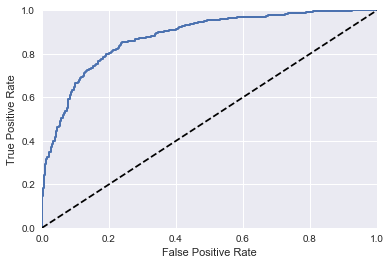

In [195]:
#Basic logistic regression ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()